# Audio Unit Selection Model - 02 Embedding 

In [1]:
import os
import warnings
import pickle as pkl
from time import time
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import librosa

import torch

from models import LinearAE

In [2]:
plt.rcParams["figure.figsize"] = (20, 10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('computing on', device)

computing on cpu


In [3]:
with open('data/unit_features.pkl', 'rb') as f:
    unit_features = pkl.load(f)

In [4]:
feature_tensors = torch.stack([torch.tensor(x, dtype=torch.float) for x in unit_features])

In [5]:
feature_tensors.shape

torch.Size([52538, 95])

In [6]:
embedding_params = {
    'feature_size': 95,
    'hidden_size': 32,
    'latent_size': 16,
    'dropout': 0.4
}

In [7]:
embedding_model = LinearAE(**embedding_params)

In [8]:
BATCH_SIZE = 32
EPOCHS = 10

In [9]:
lr = 0.0001

optimiser = torch.optim.Adam(embedding_model.parameters(), lr=lr)
cos = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
criterion = torch.nn.SmoothL1Loss(reduction='mean')

In [10]:
train_num = int(len(feature_tensors) * 0.7)
val_num = len(feature_tensors) - train_num

In [11]:
train_subset, val_subset = torch.utils.data.random_split(feature_tensors, [train_num, val_num])

In [12]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
def step(model, data, training=True):
    Q = data.to(device)
    if training:
        optimiser.zero_grad()
        
    R, _ = model(Q) 
    loss = criterion(R, Q)
    
    return loss

def fit(model, dataset):
    model.train()
    losses = []
    
    for i, data in enumerate(dataset):
        loss = step(model, data)
        losses.append(loss.item())
        loss.backward()
        optimiser.step()
        
        if i % 200 == 0 and i > 0:
            print('\t batch {:4d} | loss {:.4f}'.format(i, np.mean(losses[-50:])))
            
    return np.mean(losses[-50:])

def validate(model, dataset):
    model.eval()
    losses = []
    
    with torch.no_grad():
        for i, data in enumerate(dataset):
            loss = step(model, data, training=False)
            losses.append(loss.item())
            
    return np.mean(losses)

In [14]:
train_losses = []
val_losses = []

In [15]:
def train(model):
    train_start = time()
    print(' == Started Training model ==')

    for epoch in range(EPOCHS):
        print('Epoch {:2} of {}:'.format(epoch+1, EPOCHS))
        start = time()

        train_ds_losses = []
        val_ds_losses = []
        
        train_loss = fit(model, train_loader)
        val_loss = validate(model, val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        end_time = time() - start
        total_time = time() - train_start
        total_text = '{:02d}:{:02d}'.format(int(total_time//60), int(total_time%60))

        print('\t\t train: {:.4f} | validation: {:.4f} | epoch in {:3.2f}s | total time {}'.format(
            train_loss, val_loss, end_time, total_text))

In [19]:
try:
    train(embedding_model)
except KeyboardInterrupt:
    print('Training paused')

 == Started Training model ==
Epoch  1 of 10:
	 batch  200 | loss 0.0264
	 batch  400 | loss 0.0265
	 batch  600 | loss 0.0261
	 batch  800 | loss 0.0264
	 batch 1000 | loss 0.0264
		 train: 0.0259 | validation: 0.0186 | epoch in 1.35s | total time 00:01
Epoch  2 of 10:
	 batch  200 | loss 0.0251
	 batch  400 | loss 0.0270
	 batch  600 | loss 0.0254
	 batch  800 | loss 0.0259
	 batch 1000 | loss 0.0276
		 train: 0.0248 | validation: 0.0186 | epoch in 1.36s | total time 00:02
Epoch  3 of 10:
	 batch  200 | loss 0.0271
	 batch  400 | loss 0.0267
	 batch  600 | loss 0.0257
	 batch  800 | loss 0.0258
	 batch 1000 | loss 0.0271
		 train: 0.0267 | validation: 0.0184 | epoch in 1.32s | total time 00:04
Epoch  4 of 10:
	 batch  200 | loss 0.0262
	 batch  400 | loss 0.0254
	 batch  600 | loss 0.0263
	 batch  800 | loss 0.0260
	 batch 1000 | loss 0.0261
		 train: 0.0271 | validation: 0.0187 | epoch in 1.33s | total time 00:05
Epoch  5 of 10:
	 batch  200 | loss 0.0254
	 batch  400 | loss 0.0255


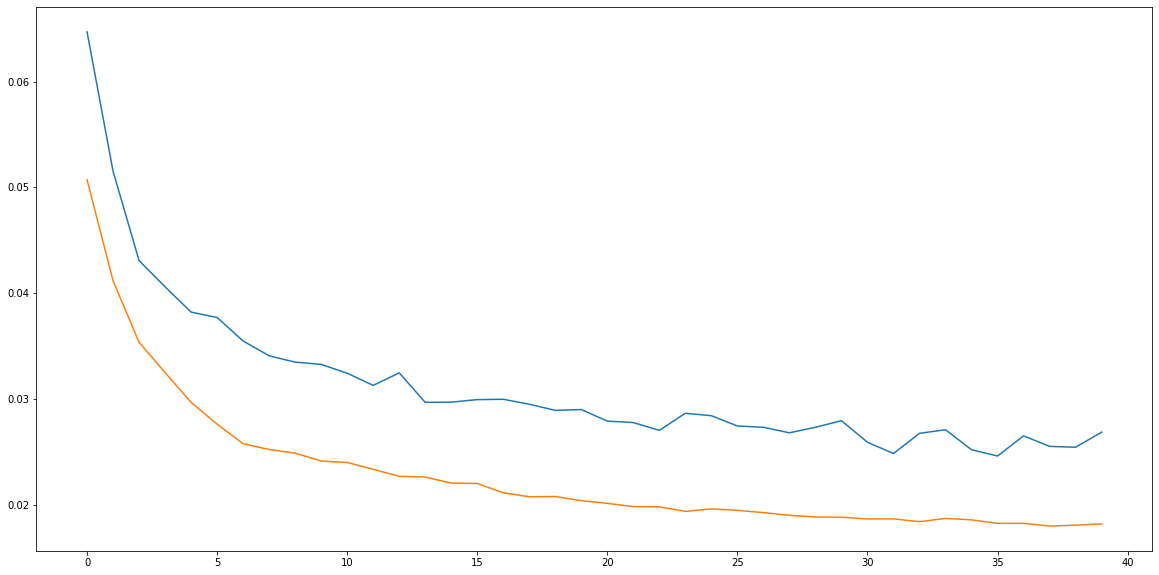

In [20]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [21]:
save_path = f'./models/{embedding_model.model_type}_embedding_model.pt'

print('Saving model to', save_path)
if not os.path.exists(os.path.split(save_path)[0]):
    print('    making dir', os.path.split(save_path)[0])
    os.mkdir(os.path.split(save_path)[0], )

torch.save({
    'model_state_dict': embedding_model.state_dict(),
    'model_params': embedding_params,
    'optimiser_state_dict': optimiser.state_dict(),
    'training_loss': train_losses,
    'validation_loss': val_losses,
}, save_path)

Saving model to ./models/AE_embedding_model.pt


In [22]:
with torch.no_grad():
    embedded = embedding_model.encode(feature_tensors.to(device))

In [23]:
embedded.shape

torch.Size([52538, 16])

In [24]:
import umap
import umap.plot

import seaborn as sns

In [25]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
umap.plot.output_notebook()

Loading BokehJS ...

In [70]:
reducer = umap.UMAP(verbose=True, n_neighbors=200, min_dist=0.99, n_components=2)

In [71]:
reducer.fit(embedded.cpu().numpy())

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.99, n_neighbors=200,
     verbose=True)
Construct fuzzy simplicial set
Wed Sep  8 01:07:19 2021 Finding Nearest Neighbors
Wed Sep  8 01:07:19 2021 Building RP forest with 16 trees
Wed Sep  8 01:07:19 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Wed Sep  8 01:08:02 2021 Finished Nearest Neighbor Search
Wed Sep  8 01:08:05 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Sep  8 01:08:45 2021 Finished embedding


UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.99, n_neighbors=200,
     verbose=True)

In [72]:
with open('./data/unit_data.pkl', 'rb') as f:
    unit_data = pkl.load(f)

In [73]:
labels = pd.DataFrame.from_dict(unit_data, orient='index')
labels['label'] = 0

In [74]:
labels.tail()

,unit_fp,measure,index,src,label
52533,./data/audio_units/52533.wav,87,5,/home/arran/Music/Collection/Yaw Evens/Memorie...,0
52534,./data/audio_units/52534.wav,87,6,/home/arran/Music/Collection/Yaw Evens/Memorie...,0
52535,./data/audio_units/52535.wav,87,7,/home/arran/Music/Collection/Yaw Evens/Memorie...,0
52536,./data/audio_units/52536.wav,87,8,/home/arran/Music/Collection/Yaw Evens/Memorie...,0
52537,./data/audio_units/52537.wav,87,9,/home/arran/Music/Collection/Yaw Evens/Memorie...,0


In [75]:
artist_ids = dict()
for id_, row in tqdm(labels.iterrows()):
    artist = row['src'].split('/')[5]
    if artist not in artist_ids:
        artist_ids[artist] = len(artist_ids)     
    labels.loc[id_, 'label'] = artist_ids[artist]

0it [00:00, ?it/s]

In [76]:
artist

'Yaw Evens'

In [77]:
reduced = reducer.transform(embedded.cpu().numpy())

In [78]:
p = umap.plot.interactive(reducer, point_size=2, labels=labels['label'])
umap.plot.show(p)

### save embeddings 

In [79]:
import json
from sklearn.preprocessing import MinMaxScaler

In [80]:
scaler = MinMaxScaler()
scaler.fit(reduced)
scaled = scaler.transform(reduced)

In [81]:
points = [pos.tolist() for pos in scaled]

data = {'points': points, 'fps': list(labels['unit_fp'])}

In [82]:
with open('./audio_vis/data.json', 'w') as f:
    f.write('d = ' + json.dumps(data))

In [83]:
with open('./models/reducer.pkl', 'wb') as f:
    pkl.dump(reducer, f)

Wed Sep  8 01:14:51 2021 Worst tree score: 0.99960029
Wed Sep  8 01:14:51 2021 Mean tree score: 0.99972758
Wed Sep  8 01:14:51 2021 Best tree score: 0.99984773
Wed Sep  8 01:14:52 2021 Forward diversification reduced edges from 10507600 to 408926
Wed Sep  8 01:14:52 2021 Reverse diversification reduced edges from 408926 to 408926
Wed Sep  8 01:14:52 2021 Degree pruning reduced edges from 482130 to 482130
Wed Sep  8 01:14:52 2021 Resorting data and graph based on tree order
Wed Sep  8 01:14:52 2021 Compressing index by removing unneeded attributes
Wed Sep  8 01:14:52 2021 Building and compiling search function
